# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

In [1]:
# Загружаем нужные библиотеки 

import pandas as pd

from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [3]:
# Загрузим библиотеку для работы с текстом, а также набот "стоп-слоб" и теггер

import nltk
nltk.download('stopwords') 
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
RANDOM_STATE = 42

In [13]:
# Функция для общей информации

def data_info(df):
    print('Первые 10 записей')
    display(df.head(10))
    print()
    print('-' * 70)
    print()
    print("Обащая информация")
    display(df.info())
    print()
    print('-' * 70)
    print()
    display(df.describe().T)
    print()
    print('-' * 70)
    print()
    print('Количество дубликатов')
    display(df.duplicated().unique())

## Подготовка

In [5]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [14]:
data_info(df)

Первые 10 записей


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0



----------------------------------------------------------------------

Обащая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None


----------------------------------------------------------------------



,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0



----------------------------------------------------------------------

Количество дубликатов


array([False])

<AxesSubplot:title={'center':'Тональность комментариев'}, ylabel='Тональность'>

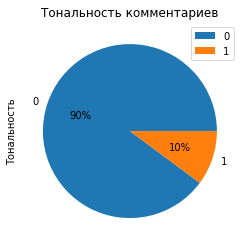

In [15]:
# Построим круглую диаграмму, чтобы посмотреть соотношение позитивных и негативных отзывов

df['toxic'].value_counts().plot(y = 'count', 
                                kind = 'pie', 
                                autopct='%1.0f%%', 
                                title = 'Тональность комментариев', 
                                legend = True, 
                                ylabel = 'Тональность')

In [16]:
# Функция обработки текста, теггирования

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [17]:
# Лемматизация текста

def lemmatize(text):
    m = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    return ' '.join([m.lemmatize(i, get_wordnet_pos(i)) for i in text])

In [18]:
tqdm.pandas()
df['new_text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [19]:
# Посмотрим результат


df.head(10)

,text,toxic,new_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i'm seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not try to edit war it's ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation from me a well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word 'nonsense' be offensive to y...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


**Вывод:**

* Пропусков в данных нет;
* Типы данных заданы корректно;
* Отрицательных отзывов в разы меньше чем положительных в соотношении 1 к 9;
* Также былаа проведена лемматизация текста и очистка от регулярных выражений.

## Обучение

In [21]:
# Разделим данные

y = df['toxic']
X = df.drop(['toxic'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
    ) 

In [22]:
# Создадим set, множество, со "стоп-словами" на английском языке

stop_words = set(stopwords.words('english'))

In [23]:
# Преобразуем текст в матрицу TF-IDF на тренировочной выборке

count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit_transform(X_train['new_text'])

In [28]:
# Преобразование текста тестовой выборки

test_tf_idf = count_tf_idf.transform(X_test['new_text'])

In [31]:
print(tf_idf)

  (0, 78033)	0.3308752594213566
  (0, 65520)	0.4039259522331161
  (0, 91535)	0.49971500455089807
  (0, 106197)	0.2347524695870796
  (0, 3721)	0.2575271947578143
  (0, 92373)	0.23357611435456094
  (0, 659)	0.34989557616378414
  (0, 3740)	0.3753752686171005
  (0, 104705)	0.1957805310027853
  (1, 107929)	0.23463353601129977
  (1, 112311)	0.134682141492955
  (1, 51739)	0.28289377866399285
  (1, 50639)	0.4099793126146299
  (1, 45445)	0.1542531717966754
  (1, 50625)	0.2528732598888444
  (1, 40077)	0.16285597081660455
  (1, 112980)	0.1405634726697469
  (1, 90196)	0.17550545234525408
  (1, 69331)	0.20390021912317077
  (1, 64669)	0.19826480539592867
  (1, 104351)	0.17447295881989822
  (1, 76168)	0.1455557317549952
  (1, 71423)	0.17943110225281822
  (1, 33819)	0.16512785004440234
  (1, 94575)	0.23945099799835962
  :	:
  (119468, 98008)	0.12639170413820486
  (119468, 93672)	0.22453368761150655
  (119468, 21940)	0.11417083100525657
  (119468, 122525)	0.11628219209009805
  (119468, 54922)	0.1147375

In [32]:
# Используем паплайны

pipe_final= Pipeline([
    ('models', LogisticRegression())
])

In [33]:
param_distributions = [
    {
        'models': [LogisticRegression()],
        'models__penalty': ['l2'],
        'models__C': [0.1, 1, 10, 100]
    },
    {
        'models': [LogisticRegression()],
        'models__penalty': ['none']
    },
    {
        'models': [CatBoostClassifier(random_state = RANDOM_STATE)],
        'models__iterations': [range(100, 601, 100)]
    }
] 

In [34]:
search = GridSearchCV(
    pipe_final, 
    param_distributions, 
    cv = 5,
    scoring='f1', 
    n_jobs=-1
)
search.fit(tf_idf, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(cv=5, estimator=Pipeline(steps=[('models', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(C=10)],
                          'models__C': [0.1, 1, 10, 100],
                          'models__penalty': ['l2']},
                         {'models': [LogisticRegression()],
                          'models__penalty': ['none']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7ffadc8185b0>],
                          'models__iterations': [range(100, 601, 100)]}],
             scoring='f1')

In [35]:
# Предсказание

new_predict = search.predict(test_tf_idf)

In [36]:
f1 = f1_score(y_test, new_predict)

print('Значение метрики f1 = ', round(f1, 3))

Значение метрики f1 =  0.773


In [37]:
print('Лучшая модель: ', search.best_estimator_)

Лучшая модель:  Pipeline(steps=[('models', LogisticRegression(C=10))])


## Выводы

В ходе выполнения проекта была проведена комплексная работа по анализу текстов комментариев и их классификации на позитивные и негативные отзывы. Загрузка датафрейма завершилась успешно, при этом обнаружено, что данные не содержат пропусков, а типы данных заданы корректно. В результате анализа распределения меток классов установлено, что 90% комментариев являются позитивными, что подчеркивает переизбыток положительных отзывов в выборке.

Для подготовки текстовых данных к моделированию выполнены следующие шаги: 
* лемматизация текста 
* очистка от шумов с помощью регулярных выражений. 
Это позволило улучшить качество входных данных и повысить точность предсказаний.

Данные были разделены на тренировочный и тестовый наборы, после чего текст был преобразован в TF-IDF матрицу, что является стандартной практикой для векторизации текстов. Дополнительно, был создан пайплайн, который обеспечил интеграцию всех этапов подготовки данных и обучения моделей.

Результаты обучения моделей логистической регрессии и CatBoost продемонстрировали высокую эффективность, при этом метрика F1 составила **0.773**, что превышает заданный порог в 0.75. Лучшая модель, полученная в процессе, это **LogisticRegression с параметром C=10**. 

Данный проект демонстрирует успешное применение методов обработки естественного языка и машинного обучения для анализа тональности комментариев. Результаты модели показывают её способность адекватно классифицировать отзывы, что может быть полезно для различных приложений в области анализа потребительских мнений и автоматизации обработки отзывов. В дальнейшем стоит рассмотреть возможность применения других алгоритмов и методов для улучшения качества предсказаний и анализа влияния различных параметров на результаты модели.